In [1]:
import os
wksp = 'D:/BaiduSyncdisk/data/Climate_Economy/'
os.chdir(wksp)
import numpy as np
import pandas as pd
from ipyleaflet import Map, Marker
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

FileNotFoundError: [Errno 2] No such file or directory: 'D:/BaiduSyncdisk/data/Climate_Economy/'

# MLP for integrating DMSP and VIIRS

Before finalizing the model, we used grid search to adjust the hyperparameters. Although sklearn provides a hyperparameter optimization method, 
it cannot meet our purpose of comparing training time and generalization ability, so we wrote our own grid search code.

In [ ]:
import numpy as np
import itertools
import multiprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import time
import scipy.stats as stats

import os

wksp = r'\\10.95.10.91\d/BaiduSyncdisk/data/Climate_Economy/'
os.chdir(wksp)
import numpy as np
import pandas as pd
from ipyleaflet import Map, Marker
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from multiprocessing import Process, Manager




def create_model(optimizer, learning_rate, activation, neurons1, neurons2, dropout_rate, input_shape):
    model = Sequential([
        Dense(neurons1, activation=activation, input_shape=(input_shape,)),
        Dropout(dropout_rate),
        Dense(neurons2, activation=activation),
        Dropout(dropout_rate),
        Dense(1)
    ])

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model


def train_and_evaluate(params, ttv_datas_all, results_list, mod_i):
    print(mod_i,'started')
    optimizer, learning_rate, neurons1, neurons2, activation, dropout_rate = params
    train_x_ht_all, train_y_ht_all, test_x_ht_all, test_y_ht_all, vali_x_ht_all, vali_y_ht_all = ttv_datas_all
    model = create_model(optimizer, learning_rate, activation, neurons1, neurons2, dropout_rate, train_x_ht_all.shape[1])
    start_time = time.time()
    history = model.fit(train_x_ht_all,
                        train_y_ht_all,
                        epochs=1000,
                        batch_size=10000,
                        # validation_split=0.05,
                        validation_data=(vali_x_ht_all, vali_y_ht_all),
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)],
                        verbose=1
                        )

    training_time = time.time() - start_time
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    pred_y_test = model.predict(test_x_ht_all, batch_size=100000)
    R_test = stats.pearsonr((np.array(test_y_ht_all)).reshape(-1, ), (pred_y_test).reshape(-1, ))[0]

    pred_y_train = model.predict(train_x_ht_all, batch_size=100000)
    R_train = stats.pearsonr((np.array(train_y_ht_all)).reshape(-1, ), (pred_y_train).reshape(-1, ))[0]

    pred_y_vali = model.predict(vali_x_ht_all, batch_size=100000)
    R_vali = stats.pearsonr((np.array(vali_y_ht_all)).reshape(-1, ), (pred_y_vali).reshape(-1, ))[0]

    print(f"Params: {params}, Loss: {train_loss:.4f},R:{R_test:.4f}, MAE: {val_loss:.4f}, Time: {training_time:.2f} sec")
    print(mod_i, 'finished')
    results_list.append((params, R_test, R_train, R_vali, train_loss, val_loss, training_time))


mod_i = 0
if __name__ == '__main__':

    continentList = ["Africa", "Asia", "Europe", "South America", "Oceania", "North America"]  #
    # 打开栅格文件
    # continentList = ["Africa"]
    train_x_ht_all = np.array([]).reshape(0, 27)
    train_y_ht_all = np.array([]).reshape(0, 1)

    test_x_ht_all = np.array([]).reshape(0, 27)
    test_y_ht_all = np.array([]).reshape(0, 1)

    vali_x_ht_all = np.array([]).reshape(0, 27)
    vali_y_ht_all = np.array([]).reshape(0, 1)

    for ste in (continentList):
        print(ste)
        data_name = 'Nei2' + ste + '2013'
        # data_df = pd.read_csv('./Light_GDP/PSO_BPNN/ALLHiLoMedianLag3_odr2'+ste+MaxLimitLab+LogDataLab+'.csv',sep = ',')
        data_df = pd.read_csv('./Light_GDP/PSO_BPNN/' + data_name + '.csv', sep=',')

        data_df.head

        # 设置随机数种子
        tf.random.set_seed(42)

        # 生成训练数据

        # XV = ['X','Y','lagnpp','lagnpp2','DistSat', 'VNPP']
        XV = ['X', 'Y'
            , 'N11', 'N12', 'N13',
              'N14', 'N0', 'N15',
              'N16', 'N17', 'N18',
              'N21', 'N22', 'N23', 'N24', 'N25', 'N26', 'N27', 'N28', 'N29', 'N210', 'N211', 'N212', 'N213', 'N214',
              'N215',
              'N216'
              ]
        YV = ['VDMSP']
        #

        data_len = data_df.shape[0]
        # train_len = int(data_df.shape[0]*0.6)
        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()
        # train_x = np.array(data_df.VNPP[0:train_len]).reshape(-1,1)
        # train_y = np.array(data_df.VDMSP[0:train_len]).reshape(-1,1)
        # train_x, test_x, train_y, test_y = train_test_split(data_df.loc[:,['X','Y','lagnpp','lagnpp2','DistSat','VNPP']], data_df.loc[:,['VDMSP']], test_size=0.4, random_state=42)

        # train_x, test_x, train_y, test_y = train_test_split(data_df.loc[:,XV], data_df.loc[:,['VDMSP']], test_size=0.4, random_state=42)
        # 分段采样
        breaks_dic = {
            'Africa': [-1, 7.057890251, 26.21502093, 53.4383119, 85.70295305, 120.9924043, 156.2818556, 188.5464967,
                       220.8111378, 300],
            'Asia': [-1, 6.049620215, 25.2067509, 53.4383119, 85.70295305, 120.9924043, 156.2818556, 189.5547667,
                     220.8111378, 300],
            'Europe': [-1, 8.066160287, 28.231561, 56.46312201, 89.73603319, 126.0337545, 160.3149357, 193.5878469,
                       226.8607581, 300],
            'North America': [-1, 7.057890251, 26.21502093, 54.44658194, 88.72776315, 126.0337545, 162.3314758,
                              197.620927,
                              231.9021082, 300],
            'Oceania': [-1, 6.049620215, 25.2067509, 54.44658194, 89.73603319, 126.0337545, 162.3314758, 197.620927,
                        230.8938382, 300],
            'South America': [-1, 6.049620215, 25.2067509, 53.4383119, 85.70295305, 120.9924043, 157.2901256,
                              192.5795768,
                              227.8690281, 300]
        }

        breaks = breaks_dic[ste]
        if 'Log' in data_name:
            breaks = np.log(breaks)
            breaks[0] = -100

        vi_train = np.array([])
        vi_test = np.array([])
        vi_vali = np.array([])
        len(breaks)
        import numpy as np

        total = 9
        max_quantile = 0.5
        quants = np.linspace(1, total, total)
        quants = np.power(quants, 2)
        quants = quants / (total ** 2) * max_quantile
        print(quants)

        for bki in range(1, len(breaks)):

            vi = np.arange(0, data_df.shape[0])
            vi_inbk = vi[np.logical_and(data_df[YV[0]] > breaks[bki - 1], data_df[YV[0]] <= breaks[bki])]
            vi_inbk_train, vi_inbk_test = train_test_split(vi_inbk, test_size=0.2)


            vi_inbk_train, vi_inbk_vali = train_test_split(vi_inbk_train, test_size=0.3)
            vi_train = np.append(vi_train, vi_inbk_train)
            vi_test = np.append(vi_test, vi_inbk_test)
            vi_vali = np.append(vi_vali, vi_inbk_vali)

        # train_x, test_x, train_y, test_y = train_test_split(data_df.loc[:,XV], data_df.loc[:,['VDMSP']], test_size=0.4, random_state=42)

        train_x = data_df.loc[vi_train, XV]
        train_y = data_df.loc[vi_train, YV]

        test_x = data_df.loc[vi_test, XV]
        test_y = data_df.loc[vi_test, YV]

        vali_x = data_df.loc[vi_vali, XV]
        vali_y = data_df.loc[vi_vali, YV]



        if True:  # Is or Not log : False for better

            XV_log = ['N11', 'N12', 'N13'
                , 'N14', 'N0', 'N15', 'N16', 'N17', 'N18'
                , 'N21', 'N22', 'N23', 'N24', 'N25', 'N26', 'N27', 'N28', 'N29', 'N210', 'N211', 'N212', 'N213', 'N214',
                      'N215', 'N216'
                      ]

            # train_y.loc[:,YV] = np.log(train_y.loc[:,YV]+1)
            train_x.loc[:, XV_log] = np.log(train_x.loc[:, XV_log] + 1)
            # vali_y.loc[:,YV] = np.log(vali_y.loc[:,YV]+1)
            vali_x.loc[:, XV_log] = np.log(vali_x.loc[:, XV_log] + 1)
            # test_y.loc[:,YV] = np.log(test_y.loc[:,YV]+1)
            test_x.loc[:, XV_log] = np.log(test_x.loc[:, XV_log] + 1)

        if True:  # Is or Not Normalization : Is for better or worse?
            scaler_x.fit_transform(data_df.loc[:, XV])
            scaler_y.fit_transform(data_df.loc[:, YV])
            train_x = scaler_x.transform(train_x)
            train_y = scaler_y.transform(train_y)
            test_x = scaler_x.transform(test_x)
            test_y = scaler_y.transform(test_y)
            vali_x = scaler_x.transform(vali_x)
            vali_y = scaler_y.transform(vali_y)
        t, train_x_ht, t1, train_y_ht = train_test_split(train_x, train_y, test_size=0.01, random_state=2)
        t, test_x_ht, t1, test_y_ht = train_test_split(test_x, test_y, test_size=0.01, random_state=2)
        t, vali_x_ht, t1, vali_y_ht = train_test_split(vali_x, vali_y, test_size=0.01, random_state=2)

        train_x_ht_all = np.concatenate([train_x_ht_all, train_x_ht])
        train_y_ht_all = np.concatenate([train_y_ht_all, train_y_ht])
        test_x_ht_all = np.concatenate([test_x_ht_all, test_x_ht])
        test_y_ht_all = np.concatenate([test_y_ht_all, test_y_ht])
        vali_x_ht_all = np.concatenate([vali_x_ht_all, vali_x_ht])
        vali_y_ht_all = np.concatenate([vali_y_ht_all, vali_y_ht])

    # Set up workspace and other configurations
    # Data loading and preprocessing
    # Define param_grid
    # Setup Manager and results_list
    # 定义超参数范围
    param_grid = {
        'model__optimizer': ['adam', 'sgd', 'rmsprop'],#,
        'model__learning_rate': [0.001, 0.01],#
        'model__neurons1': [100, 200, 300],#
        'model__neurons2': [100, 200, 300],#
        'model__activation': ['relu', 'tanh'],#
        'model__dropout_rate': [0.1, 0.2,0.3]#
    }

    #param_grid = {
    #    'model__optimizer': ['adam'],#
    #    'model__learning_rate': [0.001],#
    #    'model__neurons1': [150],#
    #    'model__neurons2': [200],#
    #    'model__activation': ['tanh'],#, 'tanh'
    #    'model__dropout_rate': [0.2]#
    #}

    # 生成参数组合
    param_combinations = list(itertools.product(
        param_grid['model__optimizer'],
        param_grid['model__learning_rate'],
        param_grid['model__neurons1'],
        param_grid['model__neurons2'],
        param_grid['model__activation'],
        param_grid['model__dropout_rate']
    ))
    ttv_datas_all = [train_x_ht_all, train_y_ht_all,test_x_ht_all,test_y_ht_all,vali_x_ht_all,vali_y_ht_all]
    # 使用多进程处理
    manager = Manager()
    results_list = manager.list()
    processes_all = []
    processes = []
    # Start multiprocessing
    for params in param_combinations:
        mod_i+=1
        print(mod_i,'initialization')
        p = Process(target=train_and_evaluate, args=(params, ttv_datas_all, results_list,mod_i))
        p.start()
        processes.append(p)
        processes_all.append(p)
        if len(processes) > 0:
            for p in processes:
                p.join()
            processes = []

    for p in processes_all:
        p.join()

    # 输出结果
    for result in results_list:
        print(result)
    print((results_list))
    results_list_df = pd.DataFrame(results_list[0:])
    results_list_df.columns = ['params', 'R_test', 'R_train', 'R_vali', 'train_loss', 'val_loss', 'training_time']
    results_list_df.to_csv(r'\\10.95.10.91\d\BaiduSyncdisk\data\Climate_Economy\Light_GDP\revised1_results/HT_results_list_01_MLP_RRR.csv')



Training model: First, divide the training set, verification set and test set into sections. Although there are literatures in the process of data processing, as the value of DMSP light increases, the value of one-sided or two-sided quantiles is continuously increased, so that better accuracy can be obtained, but there is no way to prove that these values ​​are outliers from a statistical point of view. Then this method of discarding may be problematic, so the processing of quantile discarding is not adopted. Data standardization uses the same scale as the standardization of predicted data, and cannot be standardized based on input data. Here is the multi-layer perceptron deep learning algorithm.

In [ ]:
import os
wksp = 'D:/BaiduSyncdisk/data/Climate_Economy/'
os.chdir(wksp)
import numpy as np
import pandas as pd
from ipyleaflet import Map, Marker
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
RmSat = False
MaxLimit = False
LogData = False


if MaxLimit:
    MaxLimitLab = 'MaxFilt'
else:
    MaxLimitLab = ''

if LogData:
    LogDataLab = 'Log'
else:
    LogDataLab = ''

continentList = [ "Oceania", "North America"] #  "Africa", "Asia","Europe", "South America",

continentList = ["Africa"]    
for ste in continentList:
    data_name = 'Nei2'+ste+'2013'
    #data_df = pd.read_csv('./Light_GDP/PSO_BPNN/ALLHiLoMedianLag3_odr2'+ste+MaxLimitLab+LogDataLab+'.csv',sep = ',')
    data_df = pd.read_csv('./Light_GDP/PSO_BPNN/'+data_name+'.csv',sep = ',')

    data_df.head



    # set seed
    tf.random.set_seed(42)

    #XV = ['X','Y','lagnpp','lagnpp2','DistSat', 'VNPP']
    XV = ['X','Y'
          ,'N11','N12','N13',
          'N14','N0','N15',
          'N16','N17','N18',
          'N21','N22','N23','N24','N25','N26','N27','N28','N29','N210','N211','N212','N213','N214','N215','N216'
          ]
    YV = ['VDMSP']
    
    ### Divide the data into training set, validation set and test set
    data_len = data_df.shape[0]
    #train_len = int(data_df.shape[0]*0.6)
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    breaks_dic = {'Africa':[-1,7.057890251,26.21502093,53.4383119,85.70295305,120.9924043,156.2818556,188.5464967,220.8111378,300],
              'Asia':[-1,6.049620215,25.2067509,53.4383119,85.70295305,120.9924043,156.2818556,189.5547667,220.8111378,300],
              'Europe':[-1,8.066160287,28.231561,56.46312201,89.73603319,126.0337545,160.3149357,193.5878469,226.8607581,300],
              'North America':[-1,7.057890251,26.21502093,54.44658194,88.72776315,126.0337545,162.3314758,197.620927,231.9021082,300],
              'Oceania':[-1,6.049620215,25.2067509,54.44658194,89.73603319,126.0337545,162.3314758,197.620927,230.8938382,300],
              'South America':[-1,6.049620215,25.2067509,53.4383119,85.70295305,120.9924043,157.2901256,192.5795768,227.8690281,300]
             }

    breaks = breaks_dic[ste]
    if 'Log' in data_name:
        breaks = np.log(breaks)
        breaks[0] = -100

    vi_train = np.array([])
    vi_test = np.array([])
    vi_vali = np.array([])
    len(breaks)
    import numpy as np
    total = 9
    max_quantile=0.5
    quants = np.linspace(1, total, total)  
    quants = np.power(quants, 2)
    quants = quants / (total ** 2) * max_quantile
    print(quants)
    
        
    for bki in range(1,len(breaks)):
        
        vi = np.arange(0,data_df.shape[0])
        vi_inbk = vi[np.logical_and(data_df[YV[0]]> breaks[bki-1], data_df[YV[0]] <= breaks[bki])]
        vi_inbk_train, vi_inbk_test = train_test_split(vi_inbk, test_size=0.2)

        if False: # Remove noise by distribution
            VNPP_tmp = data_df.loc[vi_inbk_train,['VNPP']]
            VDMSP_tmp = data_df.loc[vi_inbk_train,['VDMSP']]
            VNPP_Z = (VNPP_tmp - np.mean(VNPP_tmp))/np.std(VNPP_tmp)
            vi_inbk_train = vi_inbk_train[np.array(np.logical_and(VNPP_Z> -3,VNPP_Z < 3 )).reshape(-1,)]

            VNPP_tmp_test = data_df.loc[vi_inbk_test,['VNPP']]
            VDMSP_tmp_test = data_df.loc[vi_inbk_test,['VDMSP']]

            VNPP_Z_test = (VNPP_tmp_test - np.mean(VNPP_tmp_test))/np.std(VNPP_tmp_test)
            vi_inbk_test = vi_inbk_test[np.array(np.logical_and(VNPP_Z_test> -3,VNPP_Z_test < 3 )).reshape(-1,)]

        if False:# Remove Noise by quantiale

            VNPP_tmp = data_df.loc[vi_inbk_train,['VNPP']]
            VDMSP_tmp = data_df.loc[vi_inbk_train,['VDMSP']]

            vi_inbk_train = vi_inbk_train[np.array(np.logical_and(VNPP_tmp>= np.quantile(VNPP_tmp,[np.exp(-(10-bki)),0.95])[0],
                                                                  1)).reshape(-1,)]
            VNPP_tmp_test = data_df.loc[vi_inbk_test,['VNPP']]
            VDMSP_tmp_test = data_df.loc[vi_inbk_test,['VDMSP']]
            vi_inbk_test = vi_inbk_test[np.array(np.logical_and(VNPP_tmp_test>= np.quantile(VNPP_tmp_test,[np.exp(-(10-bki)),0.95])[0],
                                                                  1 )).reshape(-1,)]

        vi_inbk_train, vi_inbk_vali = train_test_split(vi_inbk_train, test_size=0.3)
        vi_train = np.append(vi_train, vi_inbk_train)
        vi_test = np.append(vi_test, vi_inbk_test)
        vi_vali = np.append(vi_vali, vi_inbk_vali)

    #train_x, test_x, train_y, test_y = train_test_split(data_df.loc[:,XV], data_df.loc[:,['VDMSP']], test_size=0.4, random_state=42)

    train_x = data_df.loc[vi_train,XV]
    train_y = data_df.loc[vi_train,YV]
    
    test_x = data_df.loc[vi_test,XV]
    test_y = data_df.loc[vi_test,YV]

    vali_x = data_df.loc[vi_vali,XV]
    vali_y = data_df.loc[vi_vali,YV]
    
    
    #np.save('./Light_GDP/PSO_BPNN/model_save/MLP_'+ste+'_vi_train.npy',vi_train)
    #np.save('./Light_GDP/PSO_BPNN/model_save/MLP_'+ste+'_vi_vali.npy',vi_vali)
    #np.save('./Light_GDP/PSO_BPNN/model_save/MLP_'+ste+'_vi_test.npy',vi_test)

    
    if True: # Is or Not log : False for better 
        
        XV_log = ['N11','N12','N13'
          ,'N14','N0','N15','N16','N17','N18'
          ,'N21','N22','N23','N24','N25','N26','N27','N28','N29','N210','N211','N212','N213','N214','N215','N216'
          ]
        
        #train_y.loc[:,YV] = np.log(train_y.loc[:,YV]+1)
        train_x.loc[:,XV_log] = np.log(train_x.loc[:,XV_log]+1)
        #vali_y.loc[:,YV] = np.log(vali_y.loc[:,YV]+1)
        vali_x.loc[:,XV_log] = np.log(vali_x.loc[:,XV_log]+1)
        #test_y.loc[:,YV] = np.log(test_y.loc[:,YV]+1)
        test_x.loc[:,XV_log] = np.log(test_x.loc[:,XV_log]+1)

    if True: # Is or Not Normalization : Is for better or worse?
        scaler_x.fit_transform(data_df.loc[:,XV])
        scaler_y.fit_transform(data_df.loc[ :,YV])
        train_x = scaler_x.transform(train_x)
        train_y = scaler_y.transform(train_y)
        test_x = scaler_x.transform(test_x)
        test_y = scaler_y.transform(test_y)
        vali_x = scaler_x.transform(vali_x)
        vali_y = scaler_y.transform(vali_y)


    # define a DNN model
    def Create_model():
        model = tf.keras.Sequential([
            #tf.keras.layers.BatchNormalization((train_x.shape[1],)),
            tf.keras.layers.Dense(200, activation='relu', # After testing different activation function, relu get a better accuracy
                                  input_shape=(train_x.shape[1],)
                                 ),
            tf.keras.layers.Dropout(0.2),

            tf.keras.layers.Dense(200, activation='relu', # After testing different activation function, relu get a better accuracy
                                  input_shape=(train_x.shape[1],)
                                 ),
            tf.keras.layers.Dropout(0.2),



            tf.keras.layers.Dense(1)
        ])

        # compile the model
        Adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
        sgd = tf.keras.optimizers.SGD(learning_rate = 0.01)
        RMSProp = tf.keras.optimizers.RMSprop(learning_rate = 0.01)
        model.compile(optimizer=Adam, loss='mse')
        return model

    model =  Create_model()
    # Train the model
    # Create a callback that saves the model's weights
    checkpoint_path = "./Light_GDP/PSO_BPNN/"+data_name+'.ckpt'
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     #save_weights_only=True,
                                                     save_best_only = True,
                                                     verbose=0)
    model.fit(train_x, 
              train_y, 
              epochs=1000, 
              batch_size=10000,
              #validation_split=0.05,
              validation_data=(vali_x, vali_y),
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)],
              verbose = 1
             )
    model.summary()
    model.save('./Light_GDP/PSO_BPNN/'+data_name+'_LogX_model.h5')
    plt.plot(model.history.history['loss'], c = 'blue')
    plt.plot(model.history.history['val_loss'], c = 'red')
    plt.show()

    # Predition
    pred_y = model.predict(test_x,batch_size=100000)

    # plot the results
    import matplotlib.pyplot as plt
    # test the model
    model.evaluate(test_x, test_y,verbose=2)
    #print('Test loss:', test_loss)
    #print('Test accuracy:', test_acc)

    #plt.plot(train_x, train_y, '.', label='train data')
    plt.plot(test_y, pred_y, '.', label='model prediction')
    plt.legend()
    plt.show()
    pred_train = model.predict(train_x)
    plt.plot(train_y, pred_train, '.', label='model prediction')
    plt.legend()
    plt.show()

    ## Correlation coefficient
    import scipy.stats as stats
    print(stats.pearsonr((np.array(test_y)).reshape(-1,), (pred_y).reshape(-1,)))
    print(stats.pearsonr((np.array(train_y)).reshape(-1,), (pred_train).reshape(-1,)))
    
 

## MLP prediction 

In [ ]:
import geopandas as gpd
import rasterio as rio
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio import Affine
import matplotlib.pyplot as plt
from rasterio.plot import show
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import jenkspy
import scipy
from scipy.spatial import distance_matrix
import scipy.stats as stats
%matplotlib inline

XV = ['X','Y'
      ,'N11','N12','N13',
      'N14','N0','N15',
      'N16','N17','N18',
      'N21','N22','N23','N24','N25','N26','N27','N28','N29','N210','N211','N212','N213','N214','N215','N216'
      ]
YV = ['VDMSP']
continentList = ["Africa","Asia", "Europe", "South America", "Oceania", "North America"] #

metric_ste = np.zeros((6,6))
#continentList = ["Asia"]
stei = -1
for ste in continentList:
    
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    data_name = 'Nei2'+ste
    for year in range(2013,2023):
        model_ste = tf.keras.models.load_model('./Light_GDP/PSO_BPNN/'+data_name+'2013_LogX_model.h5')
        #checkpoint_path = "./Light_GDP/PSO_BPNN/"+ste+'cp.ckpt'
        #model_ste = Create_model()
        #model_ste.load_weights(checkpoint_path)
        #data_df = pd.read_csv('./Light_GDP/PSO_BPNN/ALLHiLoMedianLag3_odr2'+ste+MaxLimitLab+LogDataLab+'.csv',sep = ',')
        data_df = pd.read_csv('./Light_GDP/PSO_BPNN/'+data_name+str(year)+'.csv',sep = ',')
        X = data_df.loc[:,XV]
        #model_ste= model
        if year == 2013:
            scaler_x.fit_transform(X)
            y = data_df.loc[:,YV]
            scaler_y.fit_transform(y)

            #print(model_ste.evaluate(test_x, test_y,verbose=2))
            

        XV_log = ['N11','N12','N13'
          ,'N14','N0','N15','N16','N17','N18'
          ,'N21','N22','N23','N24','N25','N26','N27','N28','N29','N210','N211','N212','N213','N214','N215','N216'
          ]
        
        X.loc[:,XV_log] = np.log(X.loc[:,XV_log]+1)

        X = scaler_x.transform(X)

        pred_y = model_ste.predict(X,batch_size=100000)
        pred_y_ori = scaler_y.inverse_transform(pred_y)
        data_df['DMSP_like_NPP'] = pred_y_ori.reshape(-1,)
        #print(pred_data.VDMSP.corr(pred_data.pred_DMSP))
        #pred_data_out = pred_data.loc[:,['rowid', 'colid', 'pred_DMSP']]

        raster_npp = rio.open("./Light_GDP/DMSL-NOAA/NPP/Continent/NPP_NTL_MaxFilt_SaturCotinMedian_"+str(year)+"Ste"+ste+".tif")
        data_npp = raster_npp.read(1)
        data_npp[data_df.rowid,data_df.colid] = data_df.DMSP_like_NPP
        out_transform = raster_npp.transform
        
        if year == 2013:
            stei+=1
            pearson_r = stats.pearsonr((np.array(y)).reshape(-1,), (pred_y_ori).reshape(-1,))
            R2 = pearson_r[0]**2
            print(R2)
            metric_ste[stei,0] = R2
            
        if False:
            if year == 2013:
                raster_dmsp = rio.open("./Light_GDP/DMSL-NOAA/DMSP/DMSP_NTL_SaturCotin_2013Ste"+ste+".tif")
                data_pre = raster_dmsp.read(1)
                data_npp[data_npp<data_pre] = data_pre[data_npp<data_pre]
                data_npp[data_npp>data_pre] = (data_pre[data_npp>data_pre]+data_npp[data_npp>data_pre])/2
                
            else:
                raster_npp = rio.open("./Light_GDP/DMSL-NOAA/Pred_NPP/PredNPPMedianLag3"+ste+str(year-1)+"tf257.tif")
                data_pre = raster_npp.read(1)
                data_npp[data_npp<data_pre] = data_pre[data_npp<data_pre]
        
        data_npp[data_npp<0] = 0
        
        ### save
        out_meta = raster_npp.meta.copy()
        out_meta.update({"driver": "GTiff", "height": data_npp.shape[0], "width": data_npp.shape[1], "transform": out_transform})

        with rasterio.open("./Light_GDP/DMSL-NOAA/Pred_NPP/NeiMLPPredNPPMedian"+ste+str(year)+"tf257.tif", "w", **out_meta,) as dest:
            dest.write(data_npp,1)
        print(str(year) + ': ' + ste)
raster_npp.close()
#raster_dmsp.close()

### HSAP

In [ ]:
import tensorflow as tf

# 如果 mse 是 Keras 内置的均方误差损失函数，则确保在加载模型时它是已知的
custom_objects = {'mse': tf.keras.losses.MeanSquaredError()}

# 模型保存路径
model_path = './Light_GDP/PSO_BPNN/{}_LogX_model.h5'.format(data_name)

# 加载模型
loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

# 打印模型结构
loaded_model.summary()
model = loaded_model

In [ ]:
from sklearn.utils import resample
import shap

local_shp = gpd.read_file(r'\\10.95.10.91\d\BaiduSyncdisk\data\Climate_Economy/Tri_State_Area_NK_Shanghai.shp')
conti_local = {"Africa":'EG', "Asia":'BJ',"Europe":'LD', "South America":None, "Oceania":None, "North America":'NK'}
local_shp[local_shp.Region == conti_local[ste]]

gid=local_shp[local_shp.Region == conti_local[ste]].index[0]

local_shp.loc[gid:gid,].plot()
gm_1 = local_shp.geometry[gid]
train_x.max(axis = 0)

data_name = 'Nei2'+ste+'2013'
#data_df = pd.read_csv('./Light_GDP/PSO_BPNN/ALLHiLoMedianLag3_odr2'+ste+MaxLimitLab+LogDataLab+'.csv',sep = ',')
data_df_ste = pd.read_csv('./Light_GDP/PSO_BPNN/'+data_name+'.csv',sep = ',')

minx,miny,maxx,maxy = gm_1.bounds
data_df_ste_1 = data_df_ste[((data_df_ste.X>minx) & (data_df_ste.X<maxx)) & ((data_df_ste.Y>miny) & (data_df_ste.Y<maxy))].copy()

XYV = ['VDMSP','X','Y'
      ,'N11','N12','N13',
      'N14','N0','N15',
      'N16','N17','N18',
      'N21','N22','N23','N24','N25','N26','N27','N28','N29','N210','N211','N212','N213','N214','N215','N216'
      ]

data_df_ste_1_thd = data_df_ste_1#[(data_df_ste_1.VDMSP>0) & (data_df_ste_1.VDMSP<100)]

XV_log = ['N11','N12','N13'
  ,'N14','N0','N15','N16','N17','N18'
  ,'N21','N22','N23','N24','N25','N26','N27','N28','N29','N210','N211','N212','N213','N214','N215','N216'
  ]
shap_X = data_df_ste_1_thd.loc[:,XV]
#train_y.loc[:,YV] = np.log(train_y.loc[:,YV]+1)
shap_X.loc[:,XV_log] = np.log(shap_X.loc[:,XV_log]+1)

sample_x = scaler_x.transform(shap_X)
sample_y = scaler_y.transform(data_df_ste_1_thd.loc[ :,YV])

background_sample = sample_x


# Interpreting the model using SHAP
explainer = shap.Explainer(model, background_sample)  # Calculate the background distribution using part of the training data
test_sample = background_sample#resample(sample_x, replace=False, n_samples=10000, random_state=42)
shap_values = explainer.shap_values(test_sample)  # Interpreting the data


import geopandas as gpd
from shapely.geometry import Point
background_sample_inv = scaler_x.inverse_transform(test_sample)




Feature Importance Distribution

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap



# Create a custom color ramp from blue to red
def rgb_to_hex(rgb):
    """Converts RGB tuple to hexadecimal color string."""
    return '#{:02x}{:02x}{:02x}'.format(*rgb)

rgb_tuple = (255, 0, 0) 
hex_color1 = rgb_to_hex((0,138,252))
hex_color2 = rgb_to_hex((255,0,82))

colors = [hex_color1, hex_color2]
nodes = [0.0, 1.0]  
cmap_name = "blue_red"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, list(zip(nodes, colors)))




fig, ax = plt.subplots()
shap.summary_plot(shap_values, test_sample,max_display = 35, feature_names=[f'{i}' for i in XV_name], plot_type='dot', show=False, layered_violin_max_num_bins=27)


plt.savefig(out_path + 'shap_summary_plot_africa_'+conti_local[ste]+'.jpg',bbox_inches='tight',pad_inches=0,dpi = 600,)

plt.show()


## LightGBM for DMSP-like conversion

Do a grid search

In [ ]:
import numpy as np
import itertools
import multiprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import time
import scipy.stats as stats

import os

wksp = r'\\10.95.10.91\d/BaiduSyncdisk/data/Climate_Economy/'
os.chdir(wksp)
import numpy as np
import pandas as pd
from ipyleaflet import Map, Marker
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from multiprocessing import Process, Manager

import lightgbm as lgb
import sklearn
import time
import jenkspy
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer




def train_and_evaluate(params, ttv_datas_all, results_list, mod_i):
    print(mod_i,'started')
    objective, max_depth, num_leaves, subsample, min_child_samples, min_child_weight, learning_rate,reg_alpha, reg_lambda = params
    train_x_ht_all, train_y_ht_all, test_x_ht_all, test_y_ht_all, vali_x_ht_all, vali_y_ht_all = ttv_datas_all
    start_time = time.time()
    #建立LGB的dataset格式数据
    lgb_train = lgb.Dataset(train_x_ht_all, train_y_ht_all)
    lgb_eval = lgb.Dataset(vali_x_ht_all, vali_y_ht_all, reference=lgb_train)

    params = {'task': 'train',
                 'boosting_type': 'gbdt',
                 'feature_fraction': 0.8,
                 'bagging_fraction': 0.8,
                 'bagging_freq': 5,
                 'verbose': 1,
                 'subsample_freq': 5,
                 'n_estimators':10000,
                 'objective': objective,
                 'metric': ['mae'],
                 'learning_rate': learning_rate,
                 'max_depth': max_depth,
                 'num_leaves': num_leaves,
                 'min_child_samples': min_child_samples,
                 'min_child_weight': min_child_weight,
                 'colsample_bytree': 0.9,
                 'subsample': subsample,
                 'reg_alpha': reg_alpha,
                 'reg_lambda': reg_lambda}
    #定义callback回调
    callback=[lgb.early_stopping(stopping_rounds=10,verbose=True),
              lgb.log_evaluation(period=10,show_stdv=True)]
    # 训练 train
    m1 = lgb.train(params,lgb_train,num_boost_round=10000,
                   valid_sets=[lgb_train,lgb_eval],callbacks=callback)

    training_time = time.time() - start_time
    train_loss = list(m1.best_score['training'].values())[0]
    val_lose = list(m1.best_score['valid_1'].values())[0]
    #预测数据集

    pred_y_test = m1.predict(test_x_ht_all, batch_size=100000)
    R_test = stats.pearsonr((np.array(test_y_ht_all)).reshape(-1, ), (pred_y_test).reshape(-1, ))[0]

    pred_y_train = m1.predict(train_x_ht_all, batch_size=100000)
    R_train = stats.pearsonr((np.array(train_y_ht_all)).reshape(-1, ), (pred_y_train).reshape(-1, ))[0]

    pred_y_vali = m1.predict(vali_x_ht_all, batch_size=100000)
    R_vali = stats.pearsonr((np.array(vali_y_ht_all)).reshape(-1, ), (pred_y_vali).reshape(-1, ))[0]


    print(f"Params: {params}, Loss: {train_loss:.4f},R:{R_test:.4f}, MAE: {val_lose:.4f}, Time: {training_time:.2f} sec")
    print(mod_i, 'finished')
    results_list.append((params,  R_test, R_train, R_vali, train_loss, val_lose, training_time))


mod_i = 0
if __name__ == '__main__':

    continentList = ["Africa", "Asia", "Europe", "South America", "Oceania", "North America"]  #
    # 打开栅格文件
    # continentList = ["Africa"]
    train_x_ht_all = np.array([]).reshape(0, 27)
    train_y_ht_all = np.array([]).reshape(0, 1)

    test_x_ht_all = np.array([]).reshape(0, 27)
    test_y_ht_all = np.array([]).reshape(0, 1)

    vali_x_ht_all = np.array([]).reshape(0, 27)
    vali_y_ht_all = np.array([]).reshape(0, 1)

    for ste in (continentList):
        print(ste)
        data_name = 'Nei2' + ste + '2013'
        # data_df = pd.read_csv('./Light_GDP/PSO_BPNN/ALLHiLoMedianLag3_odr2'+ste+MaxLimitLab+LogDataLab+'.csv',sep = ',')
        data_df = pd.read_csv('./Light_GDP/PSO_BPNN/' + data_name + '.csv', sep=',')

        data_df.head

        # 设置随机数种子
        tf.random.set_seed(42)

        # 生成训练数据

        # XV = ['X','Y','lagnpp','lagnpp2','DistSat', 'VNPP']
        XV = ['X', 'Y'
            , 'N11', 'N12', 'N13',
              'N14', 'N0', 'N15',
              'N16', 'N17', 'N18',
              'N21', 'N22', 'N23', 'N24', 'N25', 'N26', 'N27', 'N28', 'N29', 'N210', 'N211', 'N212', 'N213', 'N214',
              'N215',
              'N216'
              ]
        YV = ['VDMSP']
        #

        data_len = data_df.shape[0]
        # train_len = int(data_df.shape[0]*0.6)
        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()
        # train_x = np.array(data_df.VNPP[0:train_len]).reshape(-1,1)
        # train_y = np.array(data_df.VDMSP[0:train_len]).reshape(-1,1)
        # train_x, test_x, train_y, test_y = train_test_split(data_df.loc[:,['X','Y','lagnpp','lagnpp2','DistSat','VNPP']], data_df.loc[:,['VDMSP']], test_size=0.4, random_state=42)

        # train_x, test_x, train_y, test_y = train_test_split(data_df.loc[:,XV], data_df.loc[:,['VDMSP']], test_size=0.4, random_state=42)
        # 分段采样
        breaks_dic = {
            'Africa': [-1, 7.057890251, 26.21502093, 53.4383119, 85.70295305, 120.9924043, 156.2818556, 188.5464967,
                       220.8111378, 300],
            'Asia': [-1, 6.049620215, 25.2067509, 53.4383119, 85.70295305, 120.9924043, 156.2818556, 189.5547667,
                     220.8111378, 300],
            'Europe': [-1, 8.066160287, 28.231561, 56.46312201, 89.73603319, 126.0337545, 160.3149357, 193.5878469,
                       226.8607581, 300],
            'North America': [-1, 7.057890251, 26.21502093, 54.44658194, 88.72776315, 126.0337545, 162.3314758,
                              197.620927,
                              231.9021082, 300],
            'Oceania': [-1, 6.049620215, 25.2067509, 54.44658194, 89.73603319, 126.0337545, 162.3314758, 197.620927,
                        230.8938382, 300],
            'South America': [-1, 6.049620215, 25.2067509, 53.4383119, 85.70295305, 120.9924043, 157.2901256,
                              192.5795768,
                              227.8690281, 300]
        }

        breaks = breaks_dic[ste]
        if 'Log' in data_name:
            breaks = np.log(breaks)
            breaks[0] = -100

        vi_train = np.array([])
        vi_test = np.array([])
        vi_vali = np.array([])
        len(breaks)
        import numpy as np

        total = 9
        max_quantile = 0.5
        quants = np.linspace(1, total, total)
        quants = np.power(quants, 2)
        quants = quants / (total ** 2) * max_quantile
        print(quants)

        for bki in range(1, len(breaks)):

            vi = np.arange(0, data_df.shape[0])
            vi_inbk = vi[np.logical_and(data_df[YV[0]] > breaks[bki - 1], data_df[YV[0]] <= breaks[bki])]
            vi_inbk_train, vi_inbk_test = train_test_split(vi_inbk, test_size=0.2)

            if False:  # Remove noise by distribution
                VNPP_tmp = data_df.loc[vi_inbk_train, ['VNPP']]
                VDMSP_tmp = data_df.loc[vi_inbk_train, ['VDMSP']]
                VNPP_Z = (VNPP_tmp - np.mean(VNPP_tmp)) / np.std(VNPP_tmp)
                vi_inbk_train = vi_inbk_train[np.array(np.logical_and(VNPP_Z > -3, VNPP_Z < 3)).reshape(-1, )]

                VNPP_tmp_test = data_df.loc[vi_inbk_test, ['VNPP']]
                VDMSP_tmp_test = data_df.loc[vi_inbk_test, ['VDMSP']]

                VNPP_Z_test = (VNPP_tmp_test - np.mean(VNPP_tmp_test)) / np.std(VNPP_tmp_test)
                vi_inbk_test = vi_inbk_test[np.array(np.logical_and(VNPP_Z_test > -3, VNPP_Z_test < 3)).reshape(-1, )]

            if False:  # Remove Noise by quantiale

                VNPP_tmp = data_df.loc[vi_inbk_train, ['VNPP']]
                VDMSP_tmp = data_df.loc[vi_inbk_train, ['VDMSP']]

                vi_inbk_train = vi_inbk_train[
                    np.array(np.logical_and(VNPP_tmp >= np.quantile(VNPP_tmp, [np.exp(-(10 - bki)), 0.95])[0],
                                            1)).reshape(-1, )]
                VNPP_tmp_test = data_df.loc[vi_inbk_test, ['VNPP']]
                VDMSP_tmp_test = data_df.loc[vi_inbk_test, ['VDMSP']]
                vi_inbk_test = vi_inbk_test[
                    np.array(np.logical_and(VNPP_tmp_test >= np.quantile(VNPP_tmp_test, [np.exp(-(10 - bki)), 0.95])[0],
                                            1)).reshape(-1, )]

            vi_inbk_train, vi_inbk_vali = train_test_split(vi_inbk_train, test_size=0.3)
            vi_train = np.append(vi_train, vi_inbk_train)
            vi_test = np.append(vi_test, vi_inbk_test)
            vi_vali = np.append(vi_vali, vi_inbk_vali)

        # train_x, test_x, train_y, test_y = train_test_split(data_df.loc[:,XV], data_df.loc[:,['VDMSP']], test_size=0.4, random_state=42)

        train_x = data_df.loc[vi_train, XV]
        train_y = data_df.loc[vi_train, YV]

        test_x = data_df.loc[vi_test, XV]
        test_y = data_df.loc[vi_test, YV]

        vali_x = data_df.loc[vi_vali, XV]
        vali_y = data_df.loc[vi_vali, YV]

        # np.save('./Light_GDP/PSO_BPNN/model_save/MLP_'+ste+'_vi_train.npy',vi_train)
        # np.save('./Light_GDP/PSO_BPNN/model_save/MLP_'+ste+'_vi_vali.npy',vi_vali)
        # np.save('./Light_GDP/PSO_BPNN/model_save/MLP_'+ste+'_vi_test.npy',vi_test)

        if True:  # Is or Not log : False for better

            XV_log = ['N11', 'N12', 'N13'
                , 'N14', 'N0', 'N15', 'N16', 'N17', 'N18'
                , 'N21', 'N22', 'N23', 'N24', 'N25', 'N26', 'N27', 'N28', 'N29', 'N210', 'N211', 'N212', 'N213', 'N214',
                      'N215', 'N216'
                      ]

            # train_y.loc[:,YV] = np.log(train_y.loc[:,YV]+1)
            train_x.loc[:, XV_log] = np.log(train_x.loc[:, XV_log] + 1)
            # vali_y.loc[:,YV] = np.log(vali_y.loc[:,YV]+1)
            vali_x.loc[:, XV_log] = np.log(vali_x.loc[:, XV_log] + 1)
            # test_y.loc[:,YV] = np.log(test_y.loc[:,YV]+1)
            test_x.loc[:, XV_log] = np.log(test_x.loc[:, XV_log] + 1)

        if True:  # Is or Not Normalization : Is for better or worse?
            scaler_x.fit_transform(data_df.loc[:, XV])
            scaler_y.fit_transform(data_df.loc[:, YV])
            train_x = scaler_x.transform(train_x)
            train_y = scaler_y.transform(train_y)
            test_x = scaler_x.transform(test_x)
            test_y = scaler_y.transform(test_y)
            vali_x = scaler_x.transform(vali_x)
            vali_y = scaler_y.transform(vali_y)
        t, train_x_ht, t1, train_y_ht = train_test_split(train_x, train_y, test_size=0.01, random_state=2)
        t, test_x_ht, t1, test_y_ht = train_test_split(test_x, test_y, test_size=0.01, random_state=2)
        t, vali_x_ht, t1, vali_y_ht = train_test_split(vali_x, vali_y, test_size=0.01, random_state=2)

        train_x_ht_all = np.concatenate([train_x_ht_all, train_x_ht])
        train_y_ht_all = np.concatenate([train_y_ht_all, train_y_ht])
        test_x_ht_all = np.concatenate([test_x_ht_all, test_x_ht])
        test_y_ht_all = np.concatenate([test_y_ht_all, test_y_ht])
        vali_x_ht_all = np.concatenate([vali_x_ht_all, vali_x_ht])
        vali_y_ht_all = np.concatenate([vali_y_ht_all, vali_y_ht])

    # Set up workspace and other configurations
    # Data loading and preprocessing
    # Define param_grid
    # Setup Manager and results_list
    # 定义超参数范围

    param_distributions = {
        'objective': ['regression_l2', 'poisson', 'regression_l1'],#
        'max_depth': [20, 30, 40, 50],
        'num_leaves': [20, 40, 60, 80],
        'subsample': [0.8, 0.9],
        'min_child_samples': [18, 19, 20, 21, 22],
        'min_child_weight': [0.001],
        'learning_rate': [0.001, 0.01],#
        'reg_alpha': [0.001],
        'reg_lambda': [0.3]
    }
    # 生成参数组合
    param_combinations = list(itertools.product(
        param_distributions['objective'],
        param_distributions['max_depth'],
        param_distributions['num_leaves'],
        param_distributions['subsample'],
        param_distributions['min_child_samples'],
        param_distributions['min_child_weight'],
        param_distributions['learning_rate'],
        param_distributions['reg_alpha'],
        param_distributions['reg_lambda']

    ))

    ttv_datas_all = [train_x_ht_all, train_y_ht_all,test_x_ht_all,test_y_ht_all,vali_x_ht_all,vali_y_ht_all]
    # 使用多进程处理
    manager = Manager()
    results_list = manager.list()
    processes_all = []
    processes = []
    # Start multiprocessing
    for params in param_combinations:
        mod_i+=1
        print(mod_i,'initialization')
        p = Process(target=train_and_evaluate, args=(params, ttv_datas_all, results_list,mod_i))
        p.start()
        processes.append(p)
        processes_all.append(p)
        if len(processes) > 0:
            for p in processes:
                p.join()
            processes = []

    for p in processes_all:
        p.join()

    # 输出结果
    for result in results_list:
        print(result)
    print((results_list))
    results_list_df = pd.DataFrame(results_list[0:])
    results_list_df.columns = ['params', 'R_test', 'R_train', 'R_vali', 'train_loss', 'val_loss', 'training_time']
    results_list_df.to_csv(r'\\10.95.10.91\d\BaiduSyncdisk\data\Climate_Economy\Light_GDP\revised1_results/HT_results_list_01_LightGBM_RRR.csv')



In [3]:
import lightgbm as lgb
import sklearn
import time
import jenkspy
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

In [ ]:
metric_ste = np.zeros((6,6))
continentList = ["Africa", "Asia","Europe", "South America", "Oceania", "North America"] # 

stei = -1
for ste in continentList:
    stei +=1
    data_name = 'Nei2'+ste+'2013'
    data_df = pd.read_csv('./Light_GDP/PSO_BPNN/'+data_name+'.csv',sep = ',')

    data_df.head

    tf.random.set_seed(42)


    if 'Nei' not in data_name:
        XV = ['X','Y','lagnpp','lagnpp2', 'VNPP']
        YV = ['VDMSP'] # 'VDMSP'
    else:
        XV = ['N11','N12','N13'
          ,'N14','N0','N15','N16','N17','N18'
          ,'N21','N22','N23','N24','N25','N26','N27','N28','N29','N210','N211','N212','N213','N214','N215','N216',
            'X','Y'
          ]
        YV = ['VDMSP'] # 
        
    data_len = data_df.shape[0]
    #train_len = int(data_df.shape[0]*0.6)
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    breaks_dic = {'Africa':[-1,7.057890251,26.21502093,53.4383119,85.70295305,120.9924043,156.2818556,188.5464967,220.8111378,300],
              'Asia':[-1,6.049620215,25.2067509,53.4383119,85.70295305,120.9924043,156.2818556,189.5547667,220.8111378,300],
              'Europe':[-1,8.066160287,28.231561,56.46312201,89.73603319,126.0337545,160.3149357,193.5878469,226.8607581,300],
              'North America':[-1,7.057890251,26.21502093,54.44658194,88.72776315,126.0337545,162.3314758,197.620927,231.9021082,300],
              'Oceania':[-1,6.049620215,25.2067509,54.44658194,89.73603319,126.0337545,162.3314758,197.620927,230.8938382,300],
              'South America':[-1,6.049620215,25.2067509,53.4383119,85.70295305,120.9924043,157.2901256,192.5795768,227.8690281,300]
             }

    breaks = breaks_dic[ste]
    if 'Log' in data_name:
        breaks = np.log(breaks)
        breaks[0] = -100

    vi_train = np.array([])
    vi_test = np.array([])
    vi_vali = np.array([])
    len(breaks)
    import numpy as np

    if True:
        for bki in range(1,len(breaks)):

            vi = np.arange(0,data_df.shape[0])
            vi_inbk = vi[np.logical_and(data_df[YV[0]] > breaks[bki-1], data_df[YV[0]] <= breaks[bki])]
            vi_inbk_train, vi_inbk_test = train_test_split(vi_inbk, test_size=0.2)

            if False: # Remove noise by distribution: test
                VNPP_tmp = data_df.loc[vi_inbk_train,['VNPP']]
                VDMSP_tmp = data_df.loc[vi_inbk_train,['VDMSP']]
                VNPP_Z = (VNPP_tmp - np.mean(VNPP_tmp))/np.std(VNPP_tmp)
                vi_inbk_train = vi_inbk_train[np.array(np.logical_and(VNPP_Z> -3,VNPP_Z < 3 )).reshape(-1,)]

                VNPP_tmp_test = data_df.loc[vi_inbk_test,['VNPP']]
                VDMSP_tmp_test = data_df.loc[vi_inbk_test,['VDMSP']]

                VNPP_Z_test = (VNPP_tmp_test - np.mean(VNPP_tmp_test))/np.std(VNPP_tmp_test)
                vi_inbk_test = vi_inbk_test[np.array(np.logical_and(VNPP_Z_test> -3,VNPP_Z_test < 3 )).reshape(-1,)]

            if False:# Remove Noise by quantiale: test

                VNPP_tmp = data_df.loc[vi_inbk_train,['VNPP']]
                VDMSP_tmp = data_df.loc[vi_inbk_train,['VDMSP']]

                vi_inbk_train = vi_inbk_train[np.array(np.logical_and(VNPP_tmp>= np.quantile(VNPP_tmp,[np.exp(-(10-bki)),0.95])[0],
                                                                      1)).reshape(-1,)]
                VNPP_tmp_test = data_df.loc[vi_inbk_test,['VNPP']]
                VDMSP_tmp_test = data_df.loc[vi_inbk_test,['VDMSP']]
                vi_inbk_test = vi_inbk_test[np.array(np.logical_and(VNPP_tmp_test>= np.quantile(VNPP_tmp_test,[np.exp(-(10-bki)),0.95])[0],
                                                                      1 )).reshape(-1,)]

            vi_inbk_train, vi_inbk_vali = train_test_split(vi_inbk_train, test_size=0.3)
            vi_train = np.append(vi_train, vi_inbk_train)
            vi_test = np.append(vi_test, vi_inbk_test)
            vi_vali = np.append(vi_vali, vi_inbk_vali)
            
    else: #: test
        vi = data_df.index
        vi_train, vi_test = train_test_split(vi, test_size=0.2)      
        vi_train, vi_vali = train_test_split(vi_train, test_size=0.1)
        
    #train_x, test_x, train_y, test_y = train_test_split(data_df.loc[:,XV], data_df.loc[:,['VDMSP']], test_size=0.4, random_state=42)
    
    train_x = data_df.loc[vi_train,XV]
    train_y = data_df.loc[vi_train,YV]

    test_x = data_df.loc[vi_test,XV]
    test_y = data_df.loc[vi_test,YV]

    vali_x = data_df.loc[vi_vali,XV]
    vali_y = data_df.loc[vi_vali,YV]
    
    np.save('./Light_GDP/PSO_BPNN/model_save/LtGBM_'+ste+'_vi_train.npy',vi_train)
    np.save('./Light_GDP/PSO_BPNN/model_save/LtGBM_'+ste+'_vi_vali.npy',vi_vali)
    np.save('./Light_GDP/PSO_BPNN/model_save/LtGBM_'+ste+'_vi_test.npy',vi_test)

    if True: # Is or Not log : False for better 
        
        XV_log = ['N11','N12','N13'
          ,'N14','N0','N15','N16','N17','N18'
          ,'N21','N22','N23','N24','N25','N26','N27','N28','N29','N210','N211','N212','N213','N214','N215','N216'
          ]
        #train_y.loc[:,YV] = np.log(train_y.loc[:,YV]+1)
        train_x.loc[:,XV_log] = np.log(train_x.loc[:,XV_log]+1)
        #vali_y.loc[:,YV] = np.log(vali_y.loc[:,YV]+1)
        vali_x.loc[:,XV_log] = np.log(vali_x.loc[:,XV_log]+1)
        #test_y.loc[:,YV] = np.log(test_y.loc[:,YV]+1)
        test_x.loc[:,XV_log] = np.log(test_x.loc[:,XV_log]+1)
    
        
        

    if False: # Is or Not Normalization : Is for better or worse?
        scaler_x.fit_transform(data_df.loc[:,XV])
        scaler_y.fit_transform(data_df.loc[ :,YV])
        train_x = scaler_x.transform(train_x)
        train_y = scaler_y.transform(train_y)
        test_x = scaler_x.transform(test_x)
        test_y = scaler_y.transform(test_y)
        vali_x = scaler_x.transform(vali_x)
        vali_y = scaler_y.transform(vali_y)


    
    def median_absolute_percentage_error(y_true,y_pred):
        return np.median(np.abs((y_pred-y_true)/y_true))
    
    def regression_metrics(true,pred,pred_train,train_y,stei):
        print('Regression model evaluation index results:')
        #mse = sklearn.metrics.mean_squared_error(true, pred)
        #rmse = np.sqrt(sklearn.metrics.mean_squared_error(true,pred))
        #mae = sklearn.metrics.mean_absolute_error(true,pred)
        #MedianAE = sklearn.metrics.median_absolute_error(true,pred)
        #mape = sklearn.metrics.mean_absolute_percentage_error(true,pred)
        r2 = sklearn.metrics.r2_score(true,pred)
        r2_train = sklearn.metrics.r2_score(train_y,pred_train)

        print('R squared:', r2)
        #metric_ste[stei, :] = np.array([mse, rmse, mae, MedianAE, mape, r2])
        metric_ste[stei, 0] = r2
        metric_ste[stei, 1] = r2_train


    ### Create LGB dataset format data
    lgb_train = lgb.Dataset(train_x, train_y)
    lgb_eval = lgb.Dataset(vali_x, vali_y, reference=lgb_train)
    if True:
        params = {'task': 'train',
                     'boosting_type': 'gbdt',
                     'feature_fraction': 0.8,
                     'bagging_fraction': 0.8,
                     'bagging_freq': 5,
                     'verbose': 1,
                     'subsample_freq': 5,
                     'n_estimators':10000,
                     'objective': 'regression_l2',
                     'metric': ['mae'],
                     'learning_rate': 0.01,
                     'max_depth': 40,
                     'num_leaves': 80,
                     'min_child_samples': 20,
                     'min_child_weight': 0.001,
                     'colsample_bytree': 0.9,
                     'subsample': 0.9,
                     'reg_alpha': 0.001,
                     'reg_lambda': 0.3}
    else:
        # hyperparameters
        params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': 1,
            'subsample_freq' : 5,

            #'objective':objective,
            'objective':'poisson',#'regression_l2',#search.best_params_['objective'],#'poisson',#,
            'metric': 'mae',
            'learning_rate': 0.01,
            'max_depth':10, #search.best_params_['max_depth'],# 
            'num_leaves': 100,#search.best_params_['num_leaves'],#
            'min_child_samples': search.best_params_['min_child_samples'],
            'min_child_weight': search.best_params_['min_child_weight'],
            'colsample_bytree': search.best_params_['colsample_bytree'],
            'subsample': search.best_params_['subsample'],
            'reg_alpha': search.best_params_['reg_alpha'],
            'reg_lambda': search.best_params_['reg_lambda']


        }
    ### Define the callback callback
    callback=[lgb.early_stopping(stopping_rounds=10,verbose=True),
              lgb.log_evaluation(period=10,show_stdv=True)]
    # train
    m1 = lgb.train(params,lgb_train,num_boost_round=10000,
                   valid_sets=[lgb_train,lgb_eval],callbacks=callback)
    m1.save_model('./LtGBM_model'+data_name+'_LogX.txt')

    

    y_pred = m1.predict(test_x)
    
    pred_train = m1.predict(train_x)
    # metrics
    regression_metrics(test_y,y_pred,pred_train,train_y, stei)

### SHAP

In [117]:
data_name = 'Nei2'+ste+'2013'
#data_df = pd.read_csv('./Light_GDP/PSO_BPNN/ALLHiLoMedianLag3_odr2'+ste+MaxLimitLab+LogDataLab+'.csv',sep = ',')
data_df_ste = pd.read_csv('./Light_GDP/PSO_BPNN/'+data_name+'.csv',sep = ',')
from sklearn.utils import resample
import shap

local_shp = gpd.read_file(r'\\10.95.10.91\d\BaiduSyncdisk\data\Climate_Economy/Tri_State_Area_NK_Shanghai.shp')


conti_local = {"Africa":'ZWE_HA', "Asia":'SH',"Europe":'LD', "South America":None, "Oceania":None, "North America":'NK'}
gid=local_shp[local_shp.Region == conti_local[ste]].index[0]
local_shp.loc[gid:gid,].plot()
gm_1 = local_shp.geometry[gid]
train_x.max(axis = 0)
minx,miny,maxx,maxy = gm_1.bounds
local_shp[local_shp.Region == conti_local[ste]]

data_df_ste_1 = data_df_ste[((data_df_ste.X>minx) & (data_df_ste.X<maxx)) & ((data_df_ste.Y>miny) & (data_df_ste.Y<maxy))].copy()
XYV = ['VDMSP','X','Y'
      ,'N11','N12','N13',
      'N14','N0','N15',
      'N16','N17','N18',
      'N21','N22','N23','N24','N25','N26','N27','N28','N29','N210','N211','N212','N213','N214','N215','N216'
      ]


data_df_ste_1_thd = data_df_ste_1#[(data_df_ste_1.VDMSP>0) & (data_df_ste_1.VDMSP<100)]
print(data_df_ste_1_thd.shape)
XV = ['N11','N12','N13'
  ,'N14','N0','N15','N16','N17','N18'
  ,'N21','N22','N23','N24','N25','N26','N27','N28','N29','N210','N211','N212','N213','N214','N215','N216',
    'X','Y'
  ]
YV = ['VDMSP'] # 

XV_log = ['N11','N12','N13'
  ,'N14','N0','N15','N16','N17','N18'
  ,'N21','N22','N23','N24','N25','N26','N27','N28','N29','N210','N211','N212','N213','N214','N215','N216'
  ]
shap_X = data_df_ste_1_thd.loc[:,XV]
#train_y.loc[:,YV] = np.log(train_y.loc[:,YV]+1)
shap_X.loc[:,XV_log] = np.log(shap_X.loc[:,XV_log]+1)
shap_Y = data_df_ste_1_thd.loc[:,YV]

# Interpreting the model using SHAP
background_sample = shap_X#resample(shap_X, n_samples=1000, replace=False,random_state=42)


explainer_lgd = shap.TreeExplainer(m1,background_sample)  # Calculate the background distribution using part of the training data
test_sample = background_sample# resample(background_sample, n_samples=10000,replace=False, random_state=42)
shap_values_lgd = explainer_lgd.shap_values(test_sample)

Feature Importance Distribution

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Create a custom color ramp from blue to red


def rgb_to_hex(rgb):
    """Converts RGB tuple to hexadecimal color string."""
    return '#{:02x}{:02x}{:02x}'.format(*rgb)


rgb_tuple = (255, 0, 0)  
hex_color1 = rgb_to_hex((0,138,252))
hex_color2 = rgb_to_hex((255,0,82))

colors = [hex_color1, hex_color2]
nodes = [0.0, 1.0]  
cmap_name = "blue_red"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, list(zip(nodes, colors)))

# Draw a summary of the SHAP values ​​and remove all text
fig, ax = plt.subplots()
shap.summary_plot(shap_values_lgd, test_sample,max_display = 35, feature_names=[f'{i}' for i in XV_name], plot_type='dot', show=False, layered_violin_max_num_bins=27)

plt.savefig(out_path + 'LighGBM_shap_summary_plot_'+ste+'_'+conti_local[ste]+'.jpg',bbox_inches='tight',pad_inches=0,dpi = 600,)

plt.show()


# LightGBM prediction

In [ ]:
import lightgbm as lgb
import sklearn
import time
import jenkspy
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
import scipy.stats as stats

metric_ste = np.zeros((6,6))
continentList = [ "Africa","Asia","Europe", "South America", "Oceania", "North America"] # 

#continentList = ["Africa"]
stei = 0
XV = ['N11','N12','N13'
  ,'N14','N0','N15','N16','N17','N18'
  ,'N21','N22','N23','N24','N25','N26','N27','N28','N29','N210','N211','N212','N213','N214','N215','N216',
    'X','Y'
  ]
YV = ['VDMSP'] # 

for ste in continentList:
    data_name = 'Nei2'+ste
    ### load model
    print('load model')
    model_ste = lgb.Booster(model_file = './Light_GDP/PSO_BPNN/LtGBM_model'+data_name+'2013_LogX.txt')
    for year in range(2013,2023):
        data_df = pd.read_csv('./Light_GDP/PSO_BPNN/'+data_name+str(year)+'.csv',sep = ',')
        #checkpoint_path = "./Light_GDP/PSO_BPNN/"+ste+'cp.ckpt'
        #model_ste = Create_model()
        #model_ste.load_weights(checkpoint_path)
        
        XV_log = ['N11','N12','N13'
          ,'N14','N0','N15','N16','N17','N18'
          ,'N21','N22','N23','N24','N25','N26','N27','N28','N29','N210','N211','N212','N213','N214','N215','N216'
          ]
        X =  data_df.loc[:,XV]
        X.loc[:,XV_log] = np.log(X.loc[:,XV_log]+1)
        print('do prediction')
        y_pred = model_ste.predict(X)
        data_df['DMSP_like_NPP'] = y_pred 
        
        if year == 2013:
            stei +=1
            y = data_df.loc[:,['VDMSP']]
            pearson_r = stats.pearsonr((np.array(y)).reshape(-1,), (y_pred).reshape(-1,))
            R2 = pearson_r[0]**2
            print(R2)
            metric_ste[stei,0] = R2
            


        raster_npp = rio.open("./Light_GDP/DMSL-NOAA/NPP/Continent/NPP_NTL_MaxFilt_SaturCotinMedian_"+str(year)+"Ste"+ste+".tif")
        data_npp = raster_npp.read(1)
        data_npp[data_df.rowid,data_df.colid] = data_df.DMSP_like_NPP
        out_transform = raster_npp.transform
        

                
        data_npp[data_npp<0] = 0
        
        out_meta = raster_npp.meta.copy()
        out_meta.update({"driver": "GTiff", "height": data_npp.shape[0], "width": data_npp.shape[1], "transform": out_transform})
        print('write raster')
        with rio.open("./Light_GDP/DMSL-NOAA/Pred_NPP/NeiLtGBMPredNPPMedian"+ste+str(year)+"tf257.tif", "w", **out_meta,) as dest:
            dest.write(data_npp,1)
        print(str(year) + ': ' + ste)
raster_npp.close()
#raster_dmsp.close()

## combine two prediction

In [ ]:

import scipy.stats as stats
import rasterio as rio
import rasterio

continentList = ["Africa","Asia", "Europe", "South America", "Oceania", "North America"] #
method = 'MLP'

for ste in continentList:
    for year in range(2013,2023):
        
        #if str(year) in file and file.endswith('.tif'):
        src_MLP = rasterio.open("./Light_GDP/DMSL-NOAA/Pred_NPP/NeiMLPPredNPPMedian"+ste+str(year)+"tf257.tif",compress="lzw")
        #if src.transform[5] < 0:
         #   reproject_raster_toflUpDown(year, block)
          #  src = rasterio.open(datapath+'NPP_NTL_SaturCotin_'+str(year)+'_lon'+str(block)+'_rp.tif')
        src_LtGBM = rasterio.open("./Light_GDP/DMSL-NOAA/Pred_NPP/NeiLtGBMPredNPPMedian"+ste+str(year)+"tf257.tif",compress="lzw")
        
        src_DMSP = rio.open("./Light_GDP/DMSL-NOAA/DMSP/DMSP_NTL_SaturCotin_2013Ste"+ste+".tif")
        
        data_DMSP = src_DMSP.read()[0]
        
        
        data_MLP = src_MLP.read(1)
        data_LtGBM = src_LtGBM.read(1)
        
        if year == 2013:
            
            R2_MLP = stats.pearsonr((np.array(data_DMSP[np.logical_and(data_DMSP>0, data_MLP>0)])).reshape(-1,), 
                                (data_MLP[np.logical_and(data_DMSP>0, data_MLP>0)]).reshape(-1,))[0] ** 2

            R2_LtGBM = stats.pearsonr((np.array(data_DMSP[np.logical_and(data_DMSP>0, data_LtGBM>0)])).reshape(-1,), 
                                (data_LtGBM[np.logical_and(data_DMSP>0, data_LtGBM>0)]).reshape(-1,))[0] ** 2
        
        data_cb = ((R2_MLP/(R2_MLP+R2_LtGBM)) * data_MLP) + ((R2_LtGBM/(R2_MLP+R2_LtGBM)) * data_LtGBM)
        
    
        out_meta = src_LtGBM.meta.copy()

        with rasterio.open("./Light_GDP/DMSL-NOAA/Pred_NPP/CbNeiPredNPPMedian"+ste+str(year)+"tf257.tif", "w", **out_meta,) as dest:
            dest.write(data_cb, 1)
        print(year, ste)

src_LtGBM.close()
src_MLP.close()
src_DMSP.close()

In [33]:
del data_DMSP , data_MLP, data_cb

## Mosaic as global data

In [5]:
import geopandas as gpd
import rasterio as rio
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio import Affine
import matplotlib.pyplot as plt
from rasterio.plot import show
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import jenkspy
import scipy
from scipy.spatial import distance_matrix

In [ ]:
continentList = ["Africa","Asia", "Europe", "South America", "Oceania", "North America"] #
method = 'MLP'

for year in range(2013,2023):
    files_to_mosaic = []
    for ste in continentList:
        #if str(year) in file and file.endswith('.tif'):
        src = rasterio.open("./Light_GDP/DMSL-NOAA/Pred_NPP/CbNeiPredNPPMedian"+ste+str(year)+"tf257.tif",compress="lzw")
        #if src.transform[5] < 0:
         #   reproject_raster_toflUpDown(year, block)
          #  src = rasterio.open(datapath+'NPP_NTL_SaturCotin_'+str(year)+'_lon'+str(block)+'_rp.tif')
        files_to_mosaic.append(src)
        

    mosaic, out_transform = merge(files_to_mosaic)

    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff", "height": mosaic.shape[1], "width": mosaic.shape[2], "transform": out_transform})

    with rasterio.open("E:/0 job/data/Light_GDP/Pred_Continue/CbNeiGlobalPredNPPMedian"+str(year)+"tf257.tif", "w", **out_meta,) as dest:
        dest.write(mosaic)

    dest.close()
    src.close()
    print(str(year))

### mask outliers

In [ ]:

import scipy.stats as stats
import rasterio as rio
import rasterio

year_sum_mean_count = np.zeros((12,3))
continentList = ["Africa","Asia", "Europe", "South America", "Oceania", "North America"] #
method = 'LtGBM'

src_DMSP = rio.open("E:/0 job/data/Light_GDP/Pred_Continue/AGlobalDMSPSaturCotin"+str(2013)+".tif",compress="lzw")

mask_out = src_DMSP.read(1) <= 0

for year in range(2013,2023):
    
    src_DMSP_like = rio.open("E:/0 job/data/Light_GDP/Pred_Continue/CbNeiGlobalPredNPPMedian"+str(year)+"tf257.tif",compress="lzw")
    data_DMSP_like = src_DMSP_like.read()[0]
    data_DMSP_like[mask_out] = 0
    
    year_sum_mean_count[year-2013,0] = np.nansum(data_DMSP_like)
    year_sum_mean_count[year-2013,1] = np.nanmean(data_DMSP_like[data_DMSP_like>0])
    year_sum_mean_count[year-2013,2] = np.count_nonzero(data_DMSP_like[data_DMSP_like>0])
    
    out_meta = src_DMSP_like.meta.copy()

    with rasterio.open("E:/0 job/data/Light_GDP/Pred_Continue/CbMaskNeiGlobalPredNPPMedian"+str(year)+"tf257.tif", "w", **out_meta,) as dest:
        dest.write(data_DMSP_like, 1)
    print(year)

src_DMSP_like.close()
src_DMSP.close()

For the continuity verification of some data, although the fitting accuracy is high, the discontinuity still exists, and further continuity correction is required.

In [ ]:
year_sumv_DisConti = np.zeros((32,2))
year_sumv_Conti = np.zeros((32,2))

raster_pre = rio.open("E:/0 job/data/Light_GDP/Pred_Continue/AGlobalDMSPSaturCotin"+str(2013)+".tif")
data_pre = raster_pre.read(1)
year_sumv_DisConti[0,0] = 2012
year_sumv_DisConti[0,1] = np.nansum(data_pre)

year_sumv_Conti[0,0] = 2012
year_sumv_Conti[0,1] = np.nansum(data_pre)

raster_cur = rio.open("E:/0 job/data/Light_GDP/Pred_Continue/CbMaskNeiGlobalPredNPPMedian"+str(2013)+"tf257.tif")
data_cur = raster_cur.read(1)
year_sumv_DisConti[1,0] = 2013
year_sumv_DisConti[1,1] = np.nansum(data_cur)
out_meta = raster_cur.meta.copy()

for year in range(2013,2022):
    
    raster_aft = rio.open("E:/0 job/data/Light_GDP/Pred_Continue/CbMaskNeiGlobalPredNPPMedian"+str(year+1)+"tf257.tif")
    print(year)
    data_aft = raster_aft.read(1)
    year_sumv_DisConti[year+1-2012,0] = year+1
    year_sumv_DisConti[year+1-2012,1] = np.nansum(data_aft)
    
    data_logi = np.logical_and(data_cur<data_pre, data_aft!=0)

    data_cur[data_logi] = data_pre[data_logi]
    year_sumv_Conti[year-2012,0] = year
    year_sumv_Conti[year-2012,1] = np.nansum(data_cur)
    
    with rio.open("E:/0 job/data/Light_GDP/Pred_Continue/CtCbMaskNeiGlobalPredNPPMedian"+str(year)+"tf257.tif", "w", **out_meta,) as dest:
        dest.write(data_cur,1)
    print(year)
    data_pre = data_cur
    data_cur = data_aft

year = year +1
data_logi = data_cur<data_pre
data_cur[data_logi] = data_pre[data_logi]

year_sumv_Conti[year-2012,0] = year
year_sumv_Conti[year-2012,1] = np.nansum(data_cur)

with rio.open("E:/0 job/data/Light_GDP/Pred_Continue/CtCbMaskNeiGlobalPredNPPMedian"+str(year)+"tf257.tif", "w", **out_meta,) as dest:
    dest.write(data_cur,1)
  
        

print(year) 
raster_pre.close()
raster_cur.close()
raster_aft.close()
del data_pre,data_cur,data_aft


In [609]:
raster_pre.close()
raster_cur.close()
raster_aft.close()

<Axes: >

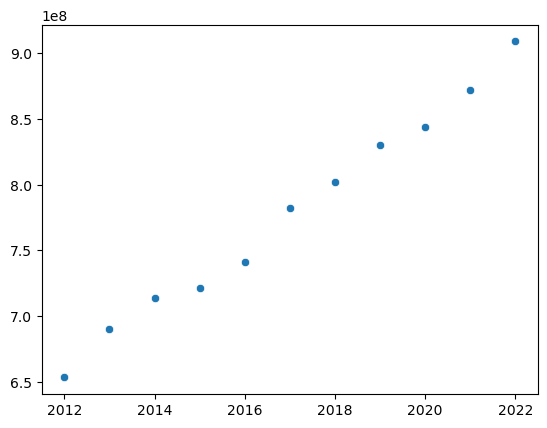

In [61]:
import seaborn as sns
sns.scatterplot(x = year_sumv_Conti[year_sumv_Conti[:,0]>0,][:,0], y = year_sumv_Conti[year_sumv_Conti[:,0]>0,][:,1])

# Light to GDP：Multilayer Perceptron

Focus on nested structures and spatial relationships

In [ ]:
import os
wksp = r''
os.chdir(wksp)
import numpy as np
import pandas as pd
from ipyleaflet import Map, Marker
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
sim_N = 100
metrics_mat = np.zeros((sim_N,4))
data_df = data_LightGDP.drop(columns='Unnamed: 0')
data_df['year_str'] = data_df['year'].copy()
data_df.loc[data_LightGDP.year == '2013b','year'] = 2013
data_df.year = data_df.year.astype('int')


# set UID and dropna
GID_act = 'GID_1'
XV = ['lCPGDP','lCPGDP_Cls', 'laglNTL_sum','lNTL_sum']#,'lCGDP','laglNTL_sum','lNTL_sum''year',
YV = ['lGDP']

#XV = ['lNTL_sum_diff','lCPGDP_Cls']#,'lCGDP','laglNTL_sum','lNTL_sum''year',
#YV = ['lGDPdiff']
data_df = data_df.dropna(subset = XV)


data_df.index = np.arange(0,data_df.shape[0])

pred_df = data_df[['GID_1', 'year_str']]

for simi in range(sim_N):

    #data_LightGDP = pd.read_csv(r'E:\0 job\data\Light_GDP\Pred_Continue\GDP/Light_GDPContiNPP_train.csv',sep = ',')
    # coby year

    data_df = data_LightGDP.drop(columns='Unnamed: 0')
    data_df['year_str'] = data_df['year']
    data_df.loc[data_LightGDP.year == '2013b','year'] = 2013
    data_df.year = data_df.year.astype('int')
    # set UID and dropna
    #XV = ['year','lCPGDP','lNTL_mean']#,'lCGDP','lCPGDP_Cls''laglNTL_sum','lNTL_sum'
    #YV = ['lGDP']
    data_df = data_df.dropna(subset = XV)
    data_df.index = np.arange(0,data_df.shape[0])

    GIDs = data_df[GID_act].unique()
    data_df['GID_act_copy'] = data_df[GID_act]

    if True:## one hot encoding
        data_df = pd.get_dummies(data_df,columns=['GID_act_copy'])
        #data_df = pd.get_dummies(data_df,columns=['year'])
        ohe_name = np.char.add(np.repeat('GID_act_copy'+'_',len(GIDs)).astype(np.str_),np.array(GIDs).astype(np.str_))
        #ohe_name_year = np.char.add(np.repeat('year'+'_',len(np.arange(1992,2022))).astype(np.str_), np.arange(1992,2022).astype(np.str_))
        #XV = ['year','lCPGDP','lCPGDP_Cls', 'laglNTL_sum','lNTL_sum']#,'lCGDP','lCPGDP_Cls''laglNTL_sum','lNTL_sum'
        X_var = np.hstack((XV, ohe_name))#ohe_name_year
    else:
        X_var = XV
        

    vi = np.arange(0,data_df.shape[0])
    pred_x = data_df.loc[np.int32(vi),X_var]
    # dropna for y
    data_df = data_df.dropna(subset = YV)
    data_df.index = np.arange(0,data_df.shape[0])


    tf.random.set_seed(simi)

    data_len = data_df.shape[0]

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()


   


    vi_train = np.array([])
    vi_test = np.array([])
    vi_vali = np.array([])
    vi = data_df.index
    for bki in data_df.GID.unique():
        vi_inbk = vi[data_df.GID == str(bki)]
        vi_inbk_train, vi_inbk_test = train_test_split(vi_inbk, test_size=0.3,random_state=simi)
        vi_inbk_train, vi_inbk_vali = train_test_split(vi_inbk_train, test_size=0.3,random_state=simi)
        vi_train = np.append(vi_train, vi_inbk_train)
        vi_test = np.append(vi_test, vi_inbk_test)
        vi_vali = np.append(vi_vali, vi_inbk_vali)

    #train_x, test_x, train_y, test_y = train_test_split(data_df.loc[:,XV], data_df.loc[:,['VDMSP']], test_size=0.4, random_state=42)

    train_x = data_df.loc[np.int32(vi_train),X_var]
    train_y = (data_df.loc[np.int32(vi_train),YV])


    test_x = data_df.loc[np.int32(vi_test),X_var]
    test_y = (data_df.loc[np.int32(vi_test),YV])

    vali_x = data_df.loc[np.int32(vi_vali),X_var]
    vali_y = (data_df.loc[np.int32(vi_vali),YV])

    test_Africa_x = test_x.loc[data_df.loc[np.int32(vi_test),'Conti_most']== 'Africa',:]
    test_Africa_y = test_y.loc[data_df.loc[np.int32(vi_test),'Conti_most']== 'Africa',:]
    test_Africa_x = test_Africa_x.append(vali_x.loc[data_df.loc[np.int32(vi_vali),'Conti_most']== 'Africa',:])
    test_Africa_y = test_Africa_y.append(vali_y.loc[data_df.loc[np.int32(vi_vali),'Conti_most']== 'Africa',:])
    print('Africa sample size: ',test_Africa_x.shape)
        
        
   
        
        
    if True: # Is or Not Normalization : Is for better or worse?
        scaler_x.fit_transform(data_df.loc[ :,X_var])
        scaler_y.fit_transform(data_df.loc[ :,YV])
        train_x = scaler_x.transform(train_x)
        train_y = scaler_y.transform(train_y)
        test_x = scaler_x.transform(test_x)
        test_y = scaler_y.transform(test_y)
        vali_x = scaler_x.transform(vali_x)
        vali_y = scaler_y.transform(vali_y)
        pred_x = scaler_x.transform(pred_x)
        test_Africa_x = scaler_x.transform(test_Africa_x)
        test_Africa_y = scaler_y.transform(test_Africa_y)


    # define a DNN model
    def Create_model():
        model = tf.keras.Sequential([
            #tf.keras.layers.BatchNormalization((train_x.shape[1],)),
            tf.keras.layers.Dense(10, activation='relu', # After testing different activation function, relu get a better accuracy
                                  #kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01,l2=0.01),
                                  #kernel_initializer='random_uniform', 
                                  input_shape=(train_x.shape[1],),use_bias=True,
                                 ),
            #tf.keras.layers.Dropout(0.2),
            
            tf.keras.layers.Dense(10, activation='relu', # After testing different activation function, relu get a better accuracy
                                  #kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01,l2=0.01),
                                  #kernel_initializer='random_uniform', 
                                  input_shape=(train_x.shape[1],),use_bias=True,
                                 ),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1)
        
        ])

        # compile the model
        Adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
        sgd = tf.keras.optimizers.SGD(learning_rate = 0.01)
        RMSProp = tf.keras.optimizers.RMSprop(learning_rate = 0.01)
        model.compile(optimizer=Adam, loss='mse')
        return model

    model =  Create_model()
    # Train the model
    # Create a callback that saves the model's weights
    checkpoint_path = 'Light_GDP2.ckpt'
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=0)
    model.fit(train_x, 
              train_y, 
              epochs=100, 
              batch_size=10000,
              #validation_split=0.05,
              validation_data=(vali_x, vali_y),
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)],
              verbose = 0
             )
    
    model.summary()
    #model.save("Light_GDP2_model_GIDLag.h5")
    plt.plot(model.history.history['loss'], c = 'blue')
    plt.plot(model.history.history['val_loss'], c = 'red')
    plt.show()

    # Predition
    pred_y = model.predict(test_x,batch_size=100000)

    # plot the results
    import matplotlib.pyplot as plt
    # test the model
    model.evaluate(test_x, test_y,verbose=2)
    #print('Test loss:', test_loss)
    #print('Test accuracy:', test_acc)

    #plt.plot(train_x, train_y, '.', label='train data')

    pred_train = model.predict(train_x)
    plt.plot(train_y, pred_train, '.', label='model train')
    plt.legend()
    plt.show()
    plt.close()
    
    pred_vali = model.predict(vali_x)
    plt.plot(vali_y, pred_vali, '.', label='model train')
    plt.legend()
    plt.show()
    plt.close()
    
    pred_test = model.predict(test_x)
    plt.plot(test_y, pred_test, '.', label='model test')
    plt.legend()
    plt.show()
    plt.close()
    
    pred_test_Africa = model.predict(test_Africa_x)
    plt.plot(test_Africa_y, pred_test_Africa, '.', label='test Africa')
    plt.legend()
    plt.show()
    plt.close()
    
    ## Correlation coefficient
    import scipy.stats as stats
    print(stats.pearsonr((np.array(train_y)).reshape(-1,), (pred_train).reshape(-1,)))
    print(stats.pearsonr((np.array(vali_y)).reshape(-1,), (pred_vali).reshape(-1,)))
    print(stats.pearsonr((np.array(test_y)).reshape(-1,), (pred_test).reshape(-1,)))
    print(stats.pearsonr(test_Africa_y.reshape(-1,), pred_test_Africa.reshape(-1,)))
    
    metrics_mat[simi,0] = stats.pearsonr((np.array(train_y)).reshape(-1,), (pred_train).reshape(-1,))[0]
    metrics_mat[simi,1] = stats.pearsonr((np.array(vali_y)).reshape(-1,), (pred_vali).reshape(-1,))[0]
    metrics_mat[simi,2] = stats.pearsonr((np.array(test_y)).reshape(-1,), (pred_test).reshape(-1,))[0]
    metrics_mat[simi,3] = stats.pearsonr(test_Africa_y.reshape(-1,), pred_test_Africa.reshape(-1,))[0]
    
    print(data_df.shape)

    ######### prediction
    import os
    wksp = r'E:\0 job\data\Light_GDP\Pred_Continue\GDP/'
    os.chdir(wksp)
    import numpy as np
    import pandas as pd
    from ipyleaflet import Map, Marker
    import geopandas as gpd
    import rasterio as rio
    import matplotlib.pyplot as plt
    from scipy.signal import convolve2d
    import tensorflow as tf

    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MinMaxScaler
    import matplotlib.pyplot as plt

    #model_pred =  tf.keras.models.load_model('./Light_GDP2_model_GIDLag.h5')
    model_pred = model
    # Predition

    pred_y = model_pred.predict(pred_x,batch_size=10000)
    pred_y = scaler_y.inverse_transform(pred_y)
    pred_df['pred'+str(simi)] = pred_y
    print(simi)
pred_df.to_csv(r'E:\0 job\data\Light_GDP\Pred_Continue\GDP/0 MLPPredGDP_Cls15onehotNonYearlCPGDPepochs100Node10.csv',sep = ',',index = False)
